In [1]:
import numpy as np
import pandas as pd
import mat73
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import scipy.io as sio
from lifelines.statistics import multivariate_logrank_test
from statsmodels.stats.multitest import multipletests
from scipy import stats
from scipy.stats import chi2_contingency
import scipy
from tqdm import tqdm
from lifelines import CoxPHFitter
from mdutils.mdutils import MdUtils
from mdutils import Html
import matplotlib

# import umap
# import umap.plot
from sklearn.cluster import KMeans
import seaborn as sns
import networkx as nx

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.inspection import permutation_importance
import sklearn.metrics as skm


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Load data

In [4]:
number_of_iterations=100

In [5]:
data = scipy.io.loadmat('data/wee1_network.mat')
ADJ = data['ADJ']
subject_list = data['subject_list']
subject_list = np.concatenate(np.concatenate(subject_list))
gene_list = data['gene_list']
gene_list = np.concatenate(np.concatenate(gene_list)) 

In [6]:
wee1_gene_list = np.unique(gene_list) 

In [12]:
import pathway_network_analysis as pna
import mmrf_data_loader 

In [13]:
patient_list, patients_mask, event_duration, censorlist = mmrf_data_loader.load_MMRF_clinical_data()

659
10
659


In [14]:
keydf = pd.read_csv('data/gene_key_8427.csv')
gene_mask = keydf['Gene'].isin(wee1_gene_list).values


In [15]:
wee1_gene_list = pna.get_common_elements(wee1_gene_list, keydf['Gene'].values)

In [16]:
data_all = scipy.io.loadmat('data/data_may4_2022.mat')
rna_data = data_all['rna_data']
rna_data = rna_data[:, patients_mask]
rna_data = rna_data[gene_mask, :]

for n in range(0, rna_data.shape[0]): 
    for m in range(0, rna_data.shape[1]): 
        rna_data[n, m] = rna_data[n, m][0][0]

In [17]:
rna_data.shape

(37, 659)

In [18]:
input_label_fn = 'data/WEE1_labels3.csv'
wee1_labels = pd.read_csv(input_label_fn)
wee1_labels = wee1_labels['label'].values
wee1_labels_mask = wee1_labels==2
wee1_labels_mask = ~wee1_labels_mask

In [19]:
np.sum(wee1_labels_mask) 

659

In [20]:
rna_data = rna_data[:, wee1_labels_mask]

In [21]:
wee1_gene_list

array(['AKT1', 'ATM', 'ATR', 'AURKB', 'BRSK2', 'BTRC', 'CABLES1', 'CCNA1',
       'CCNB1', 'CCNB2', 'CCNE1', 'CCNL2', 'CDC14A', 'CDC20', 'CDC25A',
       'CDC25B', 'CDC25C', 'CDC6', 'CDCA3', 'CDK1', 'CDK2', 'CDK6',
       'CDKN1A', 'CDR2', 'CDT1', 'CHEK1', 'CHEK2', 'CKAP5', 'FBXW11',
       'HSP90AA1', 'HSP90AB1', 'PLK1', 'PPP2R2A', 'RAD21', 'SKP2', 'TP53',
       'WEE1'], dtype='<U8')

# Predict WEE1 using all samples

In [22]:
X = rna_data[0:36, :]
y = rna_data[-1, :]
wee1_data = rna_data[-1, :]
X = X.T

In [23]:
rf = RandomForestRegressor(n_estimators=300)
skf = KFold(n_splits=5, shuffle=True)
num_of_loops = 25
run_total = num_of_loops*5

ytestlist = [] 
ypredlist = [] 
mae_list = []
rsquared_list = []

n=0
for loop_ind in tqdm(range(0, num_of_loops)): 
    for train_index, test_index in skf.split(X, y):
    
        X_train = X[train_index, :]
        X_test = X[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]     
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test) 
        
        mae = metrics.mean_absolute_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        mae_list.append(mae)
        rsquared_list.append(r2)
        ytestlist.append(y_test)
        ypredlist.append(y_pred)
        n = n + 1


ypredlist = np.concatenate(ypredlist)
ypredlist = ypredlist.astype('float')
ytestlist = np.concatenate(ytestlist)
ytestlist = ytestlist.astype('float')

print("rsquared_list", np.mean(rsquared_list))
print("mae_list", np.mean(mae_list))   
print(scipy.stats.spearmanr(ypredlist, ytestlist)) 

100%|███████████████████████████████████████████| 25/25 [03:31<00:00,  8.46s/it]

rsquared_list 0.5203065150250061
mae_list 0.7694206427238088
SignificanceResult(statistic=0.7538805412183115, pvalue=0.0)


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
perm_importance = permutation_importance(rf, X, y, n_repeats=number_of_iterations)


In [27]:
X.shape

(659, 36)

In [28]:
wee1_gene_list_x = wee1_gene_list[0:-1]

In [29]:
perm_importance.importances_mean

array([0.01959131, 0.005796  , 0.00614153, 0.00875986, 0.00770531,
       0.0097341 , 0.02390678, 0.00439669, 0.00379836, 0.00623709,
       0.00800029, 0.00791418, 0.13303945, 0.00531526, 0.00550845,
       0.01125064, 0.00473921, 0.00752387, 0.00783239, 0.01774355,
       0.01050814, 0.03388371, 0.00657444, 0.01113708, 0.03424801,
       0.2022467 , 0.0044466 , 0.00686512, 0.00742245, 0.0278951 ,
       0.00692567, 0.01295197, 0.0059921 , 0.2564946 , 0.01434298,
       0.01583699])

In [31]:
a = np.empty(len(ypredlist))
a.fill(np.mean(y))
metrics.mean_absolute_error(ytestlist, a)

1.2469465085313518

In [94]:
input_label_fn = 'data/WEE1_labels3.csv'
wee1_labels = pd.read_csv(input_label_fn)
wee1_labels = wee1_labels['label'].values
wee1_labels_hi_mask = wee1_labels==3
wee1_labels_low_mask = wee1_labels==1
# wee1_labels_mask = ~wee1_labels_mask

In [95]:
data_all = scipy.io.loadmat('data/data_may4_2022.mat')
rna_data = data_all['rna_data']
rna_data = rna_data[:, patients_mask]
rna_data = rna_data[gene_mask, :]

for n in range(0, rna_data.shape[0]): 
    for m in range(0, rna_data.shape[1]): 
        rna_data[n, m] = rna_data[n, m][0][0]

In [96]:
len(wee1_labels_hi_mask) 

659

In [97]:
high_rna_data = rna_data[:, wee1_labels_hi_mask]
X = high_rna_data[0:36, :]
y = high_rna_data[-1, :]
X = X.T

rf = RandomForestRegressor(n_estimators=300)
skf = KFold(n_splits=5, shuffle=True)
num_of_loops = 100
run_total = num_of_loops*5

ytestlist = [] 
ypredlist = [] 
mae_list = []
rsquared_list = []
permut_list = [] 


n=0
for loop_ind in tqdm(range(0, num_of_loops)): 
    for train_index, test_index in skf.split(X, y):
    
        X_train = X[train_index, :]
        X_test = X[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test) 
        
        mae = metrics.mean_absolute_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        mae_list.append(mae)
        rsquared_list.append(r2)
        ytestlist.append(y_test)
        ypredlist.append(y_pred)

        perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10)

        permut_list.append(perm_importance['importances_mean'])

        
        n = n + 1
print("rsquared_list", np.mean(rsquared_list))
print("mae_list", np.mean(mae_list))    

ypredlist = np.concatenate(ypredlist)
ypredlist = ypredlist.astype('float')
ytestlist = np.concatenate(ytestlist)
ytestlist = ytestlist.astype('float')
print(scipy.stats.spearmanr(ypredlist, ytestlist) )

100%|█████████████████████████████████████████| 100/100 [18:41<00:00, 11.22s/it]

rsquared_list 0.05299612328123324
mae_list 0.7591921230076152
SignificanceResult(statistic=0.2835798457533977, pvalue=0.0)


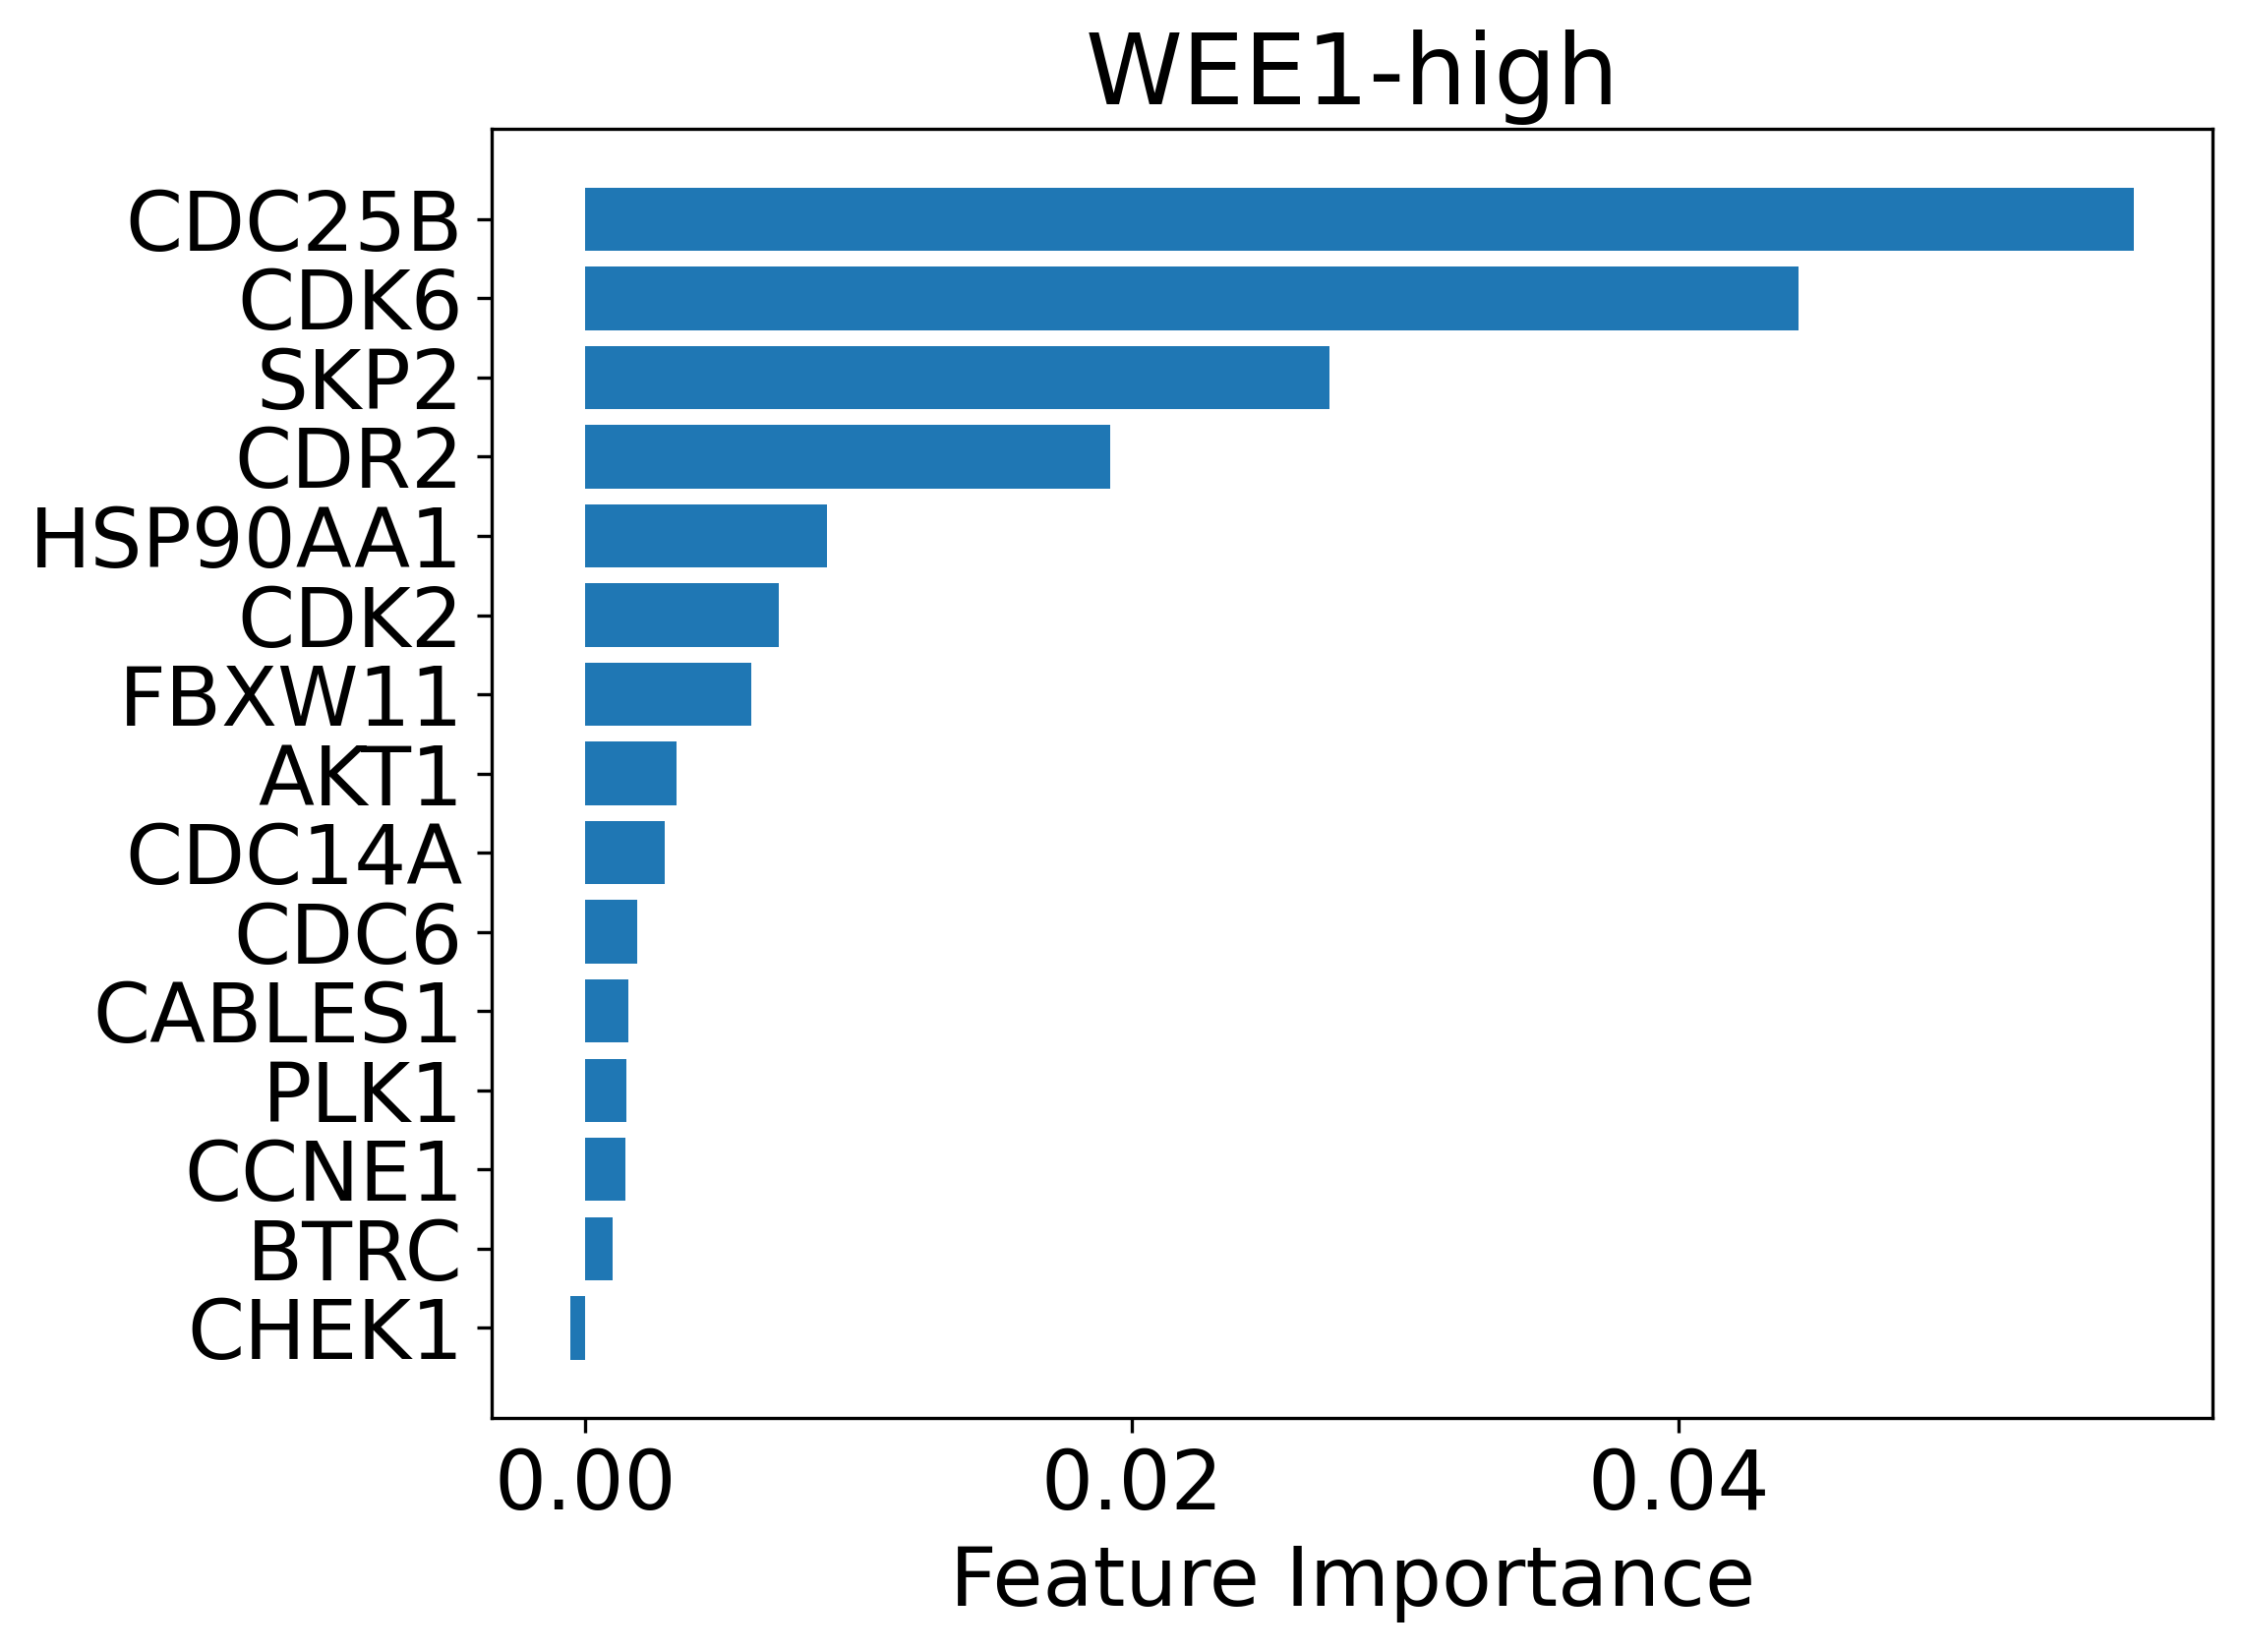

In [98]:
feat_importances = np.mean(permut_list, 0)
sorted_idx = feat_importances.argsort()
plt.figure(dpi=300, figsize=(8, 6))
plt.barh(wee1_gene_list_x[sorted_idx[-15:]], feat_importances[sorted_idx[-15:]])
plt.xlabel("Feature Importance")

plt.title('WEE1-high')
plt.rcParams.update({'font.size': 20})

plt.tight_layout()

plt.savefig('RF_WEE1_high.png')



In [99]:
low_rna_data = rna_data[:, wee1_labels_low_mask]
X = low_rna_data[0:36, :]
y = low_rna_data[-1, :]
X = X.T

rf = RandomForestRegressor(n_estimators=300)
skf = KFold(n_splits=5, shuffle=True)
num_of_loops = 100
run_total = num_of_loops*5

ytestlist = [] 
ypredlist = [] 
mae_list = []
rsquared_list = []
permut_list = [] 

n=0
for loop_ind in tqdm(range(0, num_of_loops)): 
    for train_index, test_index in skf.split(X, y):
    
        X_train = X[train_index, :]
        X_test = X[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test) 
        
        mae = metrics.mean_absolute_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        mae_list.append(mae)
        rsquared_list.append(r2)
        ytestlist.append(y_test)
        ypredlist.append(y_pred)
        
        perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10)
        permut_list.append(perm_importance['importances_mean'])

        n = n + 1
print("rsquared_list", np.mean(rsquared_list))
print("mae_list", np.mean(mae_list))    

ypredlist = np.concatenate(ypredlist)
ypredlist = ypredlist.astype('float')
ytestlist = np.concatenate(ytestlist)
ytestlist = ytestlist.astype('float')
print(scipy.stats.spearmanr(ypredlist, ytestlist))

100%|█████████████████████████████████████████| 100/100 [17:40<00:00, 10.60s/it]

rsquared_list 0.3653286575166328
mae_list 0.23830044594250221
SignificanceResult(statistic=0.596038494759041, pvalue=0.0)


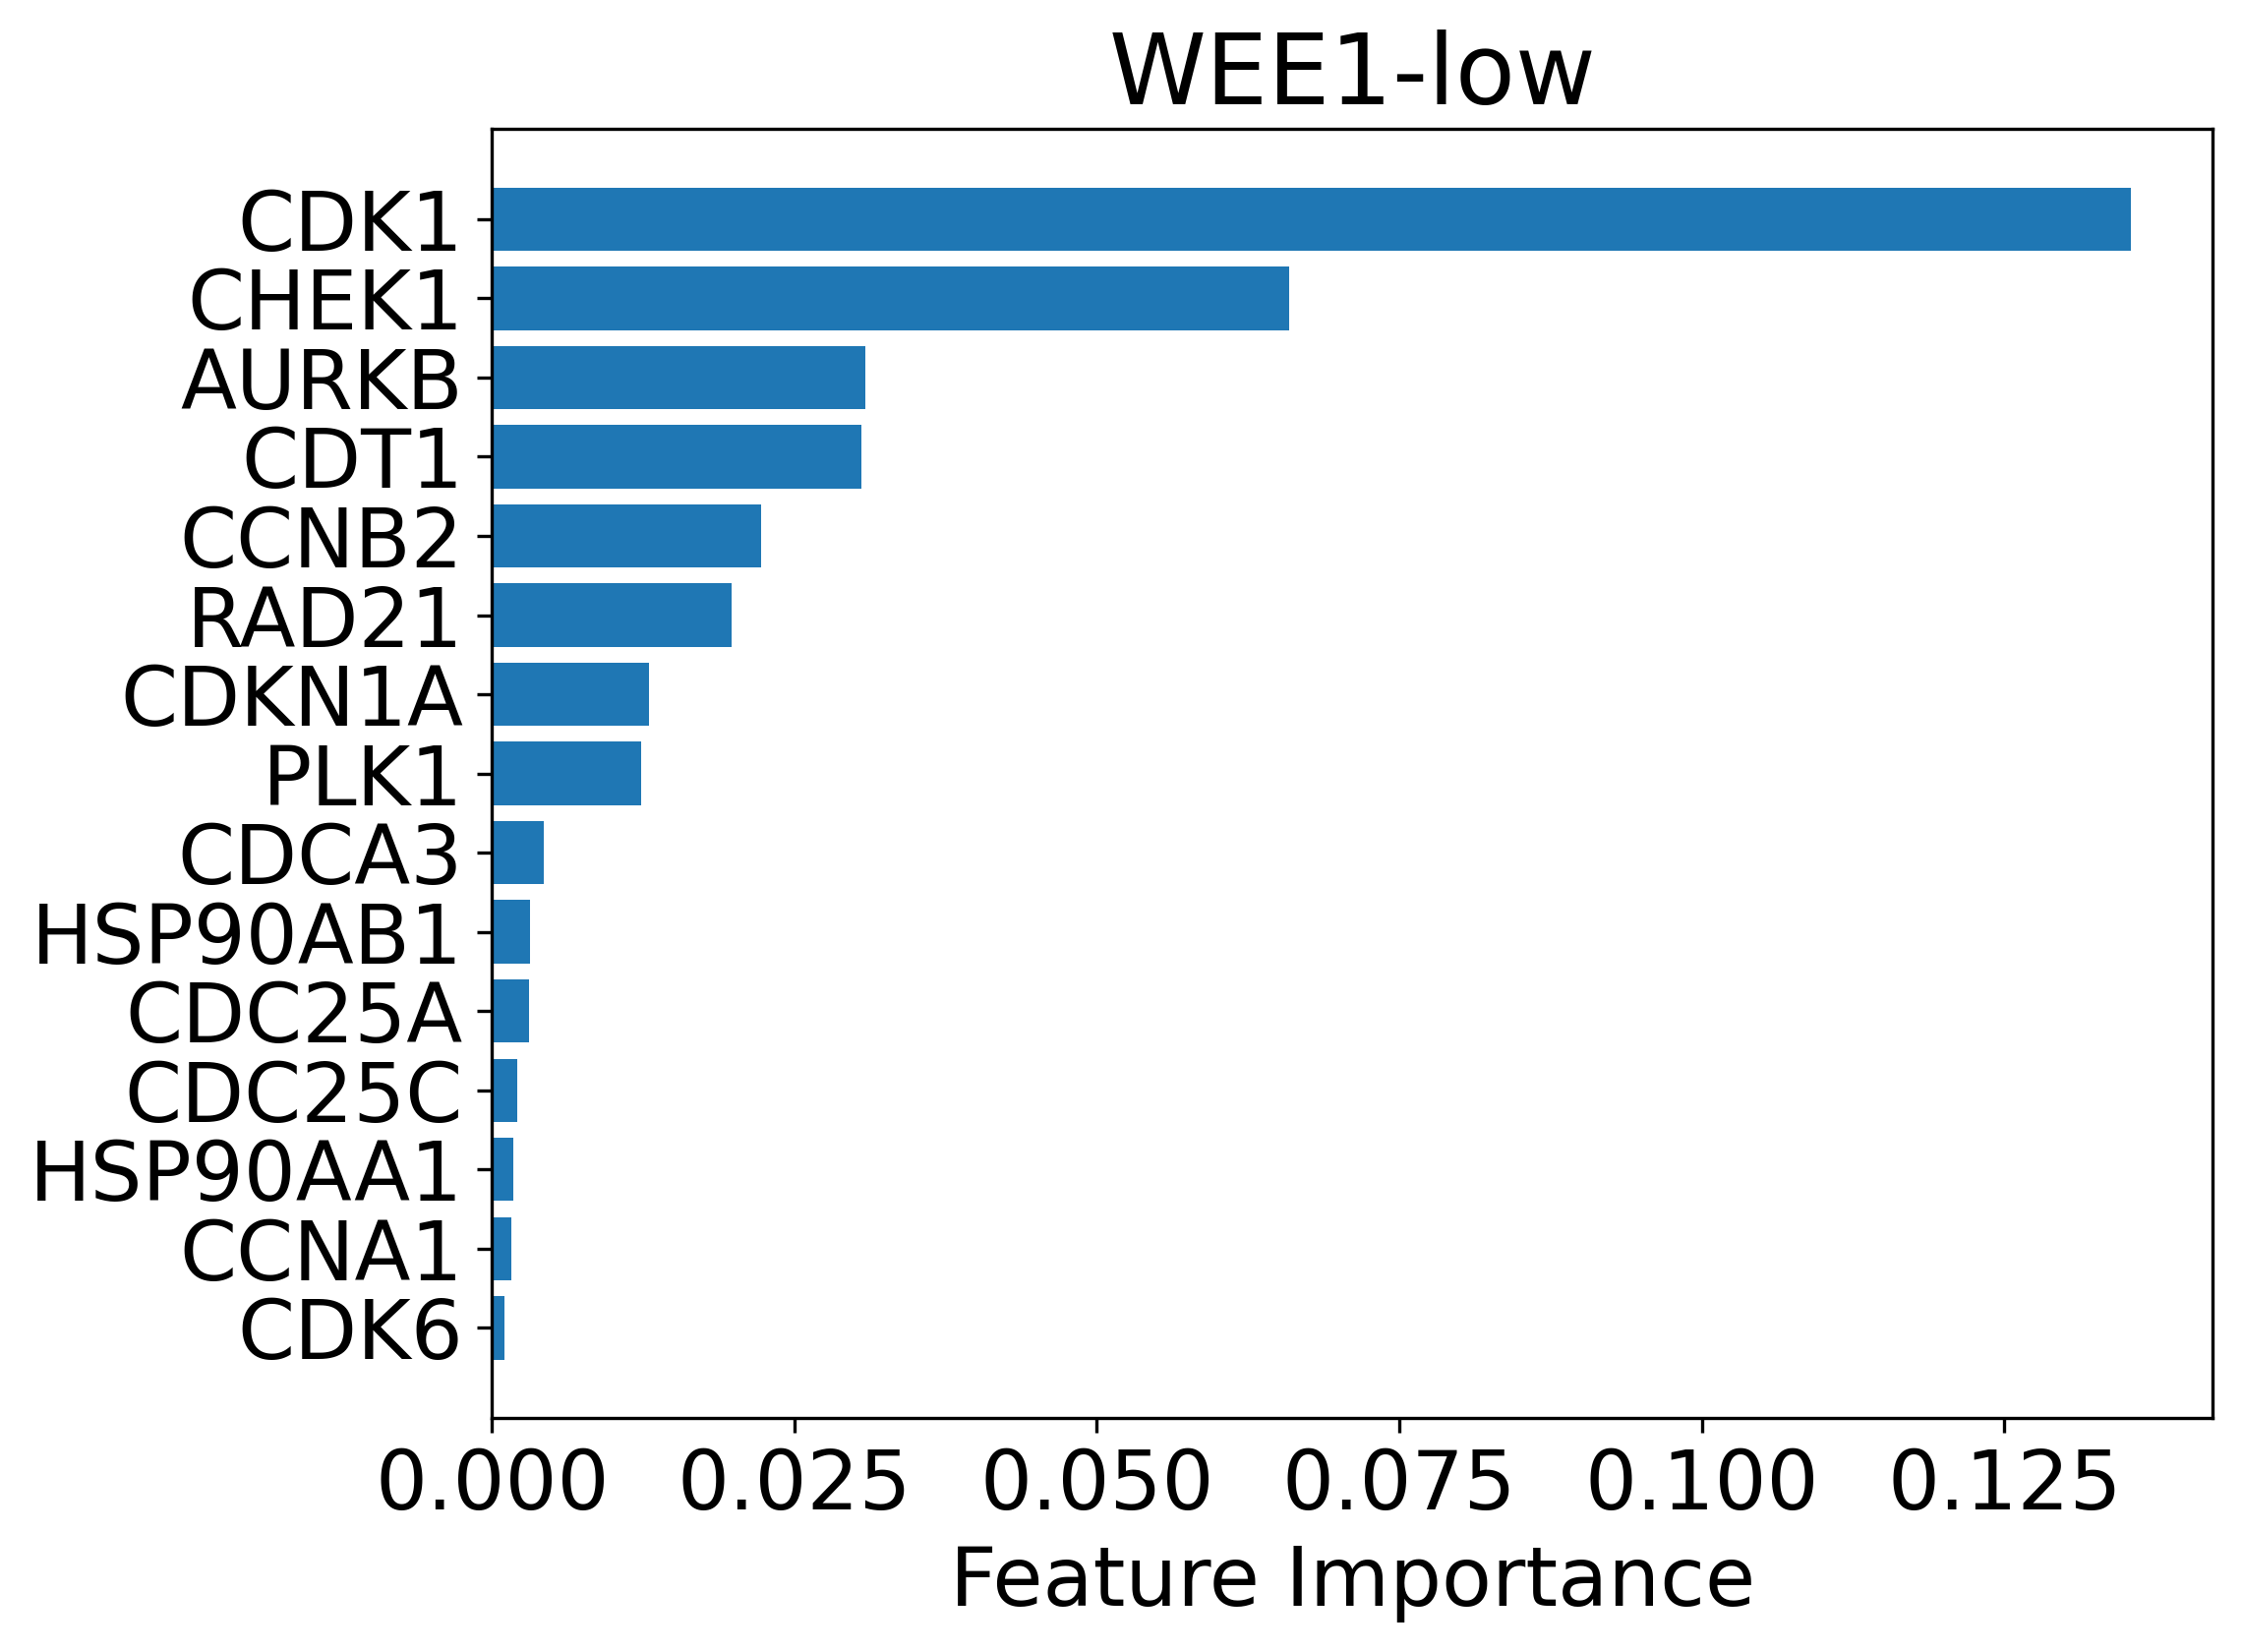

In [101]:
feat_importances = np.mean(permut_list, 0)
sorted_idx = feat_importances.argsort()
plt.figure(dpi=300, figsize=(8, 6))
plt.barh(wee1_gene_list_x[sorted_idx[-15:]], feat_importances[sorted_idx[-15:]])
plt.xlabel("Feature Importance")

plt.title('WEE1-low')
plt.rcParams.update({'font.size': 20})

plt.tight_layout()

plt.savefig('RF_WEE1_low.png')

